# **Feature Extraction from FC-2 Layer VGG-16**

---



In [1]:
!echo 'tqdm\ntables\nfalconn\nPyDrive' > requirements.txt
!pip install -r requirements.txt

    100% |████████████████████████████████| 51kB 3.6MB/s 
    100% |████████████████████████████████| 3.8MB 8.2MB/s 
    100% |████████████████████████████████| 1.4MB 18.6MB/s 
    100% |████████████████████████████████| 993kB 15.2MB/s 
    100% |████████████████████████████████| 174kB 19.4MB/s 
  Running setup.py bdist_wheel for falconn ... done
  Stored in directory: /content/.cache/pip/wheels/bf/36/96/d5538901888620fc0343c1ed9d5f87fce00869e00c12056ef8
  Running setup.py bdist_wheel for PyDrive ... done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built falconn PyDrive


In [2]:
import random
import numpy as np
import pandas as pd
import _pickle as pickle
from pprint import pprint

import matplotlib.pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input as preprocess_input_vgg
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inc
from keras.utils.np_utils import to_categorical
from keras.models import Model, load_model
from keras import metrics

#from scipy.spatial import distance
#from sklearn.model_selection import train_test_split
from tqdm import tqdm

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import psutil
from tensorflow.python.client import device_lib

import tables
import falconn
#from annoy import AnnoyIndex

Using TensorFlow backend.


**Upload following files:**


*   train.txt
*   test.txt
*   cookies.txt (session from OneDrive)
*   client_secrets.json (Upload trained model to Google Drive)



In [3]:
uploaded = files.upload()

with open("cookies.txt", 'wb') as f:
    f.write(uploaded[list(uploaded.keys())[0]])

Saving cookies.txt to cookies.txt


In [ ]:
!rm cookies\ \(1\).txt

**Download following files and unzip them:**

*   chunk_1.zip
*   chunk_2.zip

If existing model wants to be continued learning:

*   inceptionv3_newest.hdf5

In [4]:
!mkdir images
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fmeta%2Ftest%2Etxt > test.txt
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fmeta%2Ftrain%2Etxt > train.txt
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fimages%2Fchunk%5F1%2Ezip > chunk_1.zip
!unzip -q chunk_1.zip -d images
!rm chunk_1.zip
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fimages%2Fchunk%5F2%2Ezip > chunk_2.zip
!unzip -q chunk_2.zip -d images
!rm chunk_2.zip
!rm -r images/__MACOSX/
!find images -print | wc -l 
!find images -name "*.jpg" -size -1k -delete
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Ffeatures%2Fvgg16%5Fbottleneck%5Ffeatures%2Ehdf5 > vgg16_bottleneck_features.hdf5
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fmodels%2Finceptionv3%5F4%5Fnew%5Fohne%5Fdpot%5F2%2E97270%2Ehdf5 > incep.hdf5
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fmeta%2Fclasses%5F230%2Etxt > classes_230.txt
!curl -b cookies.txt https://kantiolten-my.sharepoint.com/personal/muriz_serifovic_kantiolten_ch/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fmuriz%5Fserifovic%5Fkantiolten%5Fch%2FDocuments%2FMachine%20Learning%2Fmeta%2Fchefkoch%5Fmerged%5Flists%5F05%5Fmay%2Ecsv > chefkoch.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3213k  100 3213k    0     0  1071k      0  0:00:03  0:00:03 --:--:--  848k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.5M  100 12.5M    0     0  2573k      0  0:00:05  0:00:05 --:--:-- 3388k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 54 7861M   54 4272M    0     0  33.1M      0  0:03:57  0:02:09  0:01:48 25.8M100 7861M  100 7861M    0     0  30.5M      0  0:04:17  0:04:17 --:--:-- 28.4M
warning [chunk_1.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #1

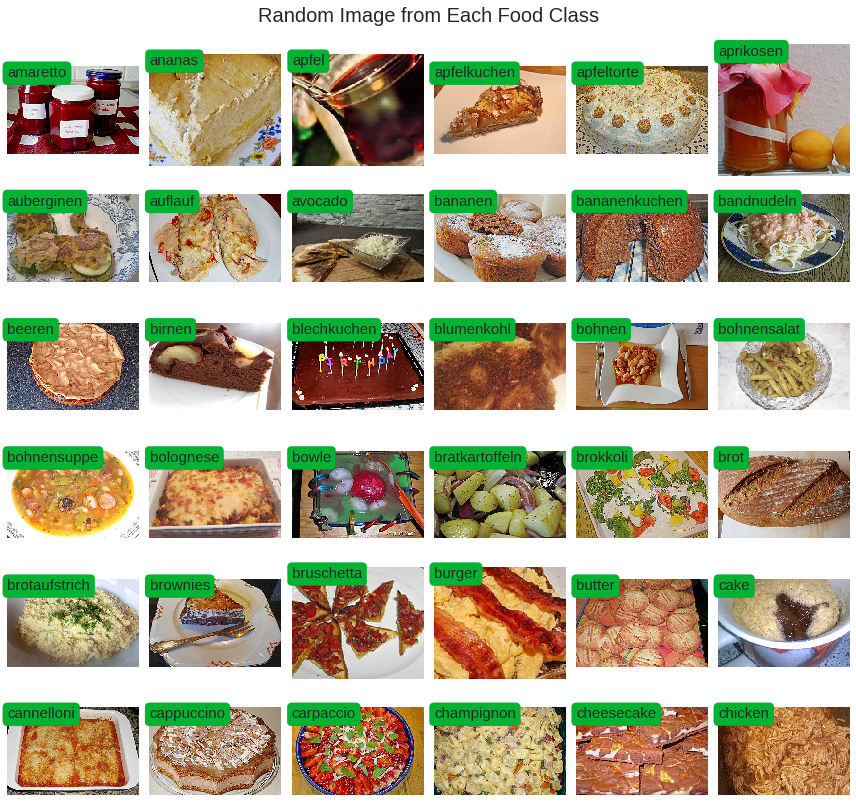

In [5]:
root_dir = 'images/'
rows = 6
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(12, 12))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, 0, food_dir, size=15, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [35]:
print(device_lib.list_local_devices())
print(psutil.virtual_memory())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12339531107331529907
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11288962663
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15824582483568204966
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
svmem(total=13662035968, available=3119808512, percent=77.2, used=9308631040, free=206462976, active=10618613760, inactive=2178105344, buffers=60502016, cached=4086439936, shared=974102528, slab=453095424)


In [7]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   29G  312G   9% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/root       1.2G  537M  684M  44% /opt/bin
tmpfs           6.4G  248M  6.2G   4% /usr/lib64-nvidia
/dev/sda1       365G   47G  319G  13% /etc/hosts
shm              64M  4.0K   64M   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [8]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

514678784/553467096 [==========================>...] - ETA: 2s553467904/553467096 [==============================] - 32s 0us/step


In [ ]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image_vgg(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_vgg(x)
    return img, x
  
def get_image_inc(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_inc(x)
    return img, x
  
def plot_preds(image, preds, top_n):  
    plt.imshow(image)
    plt.axis('off')
    plt.figure()
    
    order = list(reversed(range(top_n)))
    labels = [categories[x] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    bar_preds = [-np.sort(-probabilities)[i] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    
    plt.barh(order, bar_preds, alpha=0.8, color='g')
    plt.yticks(order, labels, color='g')
    plt.xlabel('Probability', color='g')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()

def show_result_images(final_result):
    rows = 2
    cols = 3
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(12, 12))
    fig.suptitle('Result Images from Query', fontsize=20)
    food_dirs = [food_direction[4] for food_direction in final_result]
    for i in range(rows):
      for j in range(cols):
        food_dir = food_dirs[i*cols + j]
        img = plt.imread(food_dir)
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (1, 1, 1)
        ax[i][j].text(0, 0, get_corresponding_recipes(final_result).recipe_name[i*cols + j], size=15, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

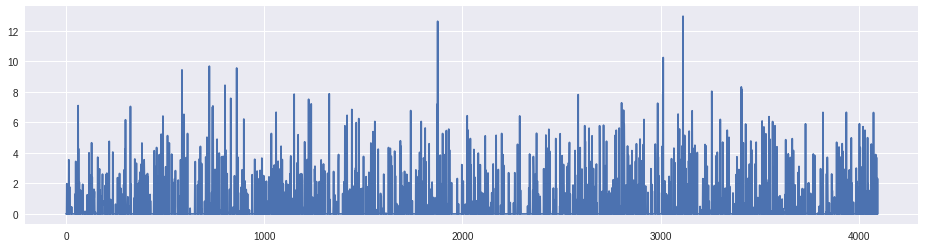

In [10]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
img, x = get_image_vgg("images/kuchen/kuchen-23101005746336-39.jpg.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

In [ ]:
images_path = 'images'
max_num_images = 420000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 403885 images to analyze


In [ ]:
all_ids = []
for im in images:
  id_im = im.split('-')[1]
  all_ids.append(id_im)

In [ ]:
set_all_ids = set(all_ids)
print(len(set_all_ids))

90301


**We have 90'301 different recipes at the moment for our service.**

In [ ]:
hdf5_path = 'vgg16_bottleneck_features.hdf5'

In [ ]:
data_shape = (0, 4096)
img_dtype = tables.Float32Atom()

hdf5_file = tables.open_file(hdf5_path, mode='w')

hdf5_file.create_array(hdf5_file.root, 'img_paths', images)
features = hdf5_file.create_earray(hdf5_file.root, 'img_features', img_dtype, shape=data_shape)

for image_path in tqdm(images):
    img, x = get_image_vgg(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat[None])
    
hdf5_file.close()

100%|██████████| 2000/2000 [01:15<00:00, 26.47it/s]


In [ ]:
feat_nparry = np.array(features)
feat_nparry.shape

(1000, 4096)

In [ ]:
hdf5_file = tables.open_file(hdf5_path, mode='r')
features = hdf5_file.root.img_features
images = hdf5_file.root.img_paths

In [ ]:
t = AnnoyIndex(4096)

for i, v in enumerate(tqdm(features[:70000])):
  t.add_item(i, v)
  
t.build(32)
t.save('annoy_index_32_trees.ann')

100%|██████████| 70000/70000 [00:35<00:00, 1967.29it/s]


True

In [ ]:
t = AnnoyIndex(4096)
t.load('annoy_index_32_trees.ann')

True

In [13]:
%%time
n = 403885
d = 4096

#number_of_tables = 50
#params_cp = falconn.LSHConstructionParameters()
#params_cp.dimension = len(features[0])
#params_cp.lsh_family = falconn.LSHFamily.Hyperplane
#params_cp.distance_function = falconn.DistanceFunction.EuclideanSquared
#params_cp.l = number_of_tables


p = falconn.get_default_parameters(n, d)
t = falconn.LSHIndex(p)
t.setup(features[:])
q = t.construct_query_object(num_probes=32)

CPU times: user 3min 51s, sys: 7.78 s, total: 3min 59s
Wall time: 2min 35s


In [ ]:
def get_closest_images_bruteforce(query_features, num_results=5):
    # TODO: Too slow -> scipy.spatial.distance.euclidean
    distances = [ distance.euclidean(query_features, feat) for feat in features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest
  
def get_closest_images_fast(query_features, num_results=15):
    return q.find_k_nearest_neighbors(query_features, num_results)
  
def get_closest_images_fast_annoy(query_features, num_results=6):
    return t.get_nns_by_vector(query_features, num_results)
    
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [ ]:
def top_10_accuracy(y_true, y_pred):
  return metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)

model_inc = load_model(filepath='incep.hdf5', custom_objects={'top_10_accuracy': top_10_accuracy})

with open('classes_230.txt', 'r') as f:
    categories = f.read().splitlines()

In [ ]:
chefkoch_rezepte = pd.read_csv('chefkoch.csv', index_col=False)

In [ ]:
#chefkoch_rezepte.query('recipe_id in @names')
#chefkoch_rezepte.loc[chefkoch_rezepte['recipe_name'].isin([recipe_id_single[2] for recipe_id_single in final_result])]
#idx_pandas = pd.Index(chefkoch_rezepte['recipe_name']).get_indexer([recipe_id_single[2] for recipe_id_single in final_result])
#chefkoch_rezepte.loc[[recipe_id_single[2] for recipe_id_single in final_result]]

In [ ]:
def get_corresponding_recipes(final_results, chefkoch_rezepte=chefkoch_rezepte):
  chefkoch_rezepte_result = pd.DataFrame()
  for recipe_id_single in final_results:
    chefkoch_rezepte_result = chefkoch_rezepte_result.append(chefkoch_rezepte.query('recipe_id in @recipe_id_single[2]'), ignore_index=True)
  return chefkoch_rezepte_result

Scheme of final result:

```
01. ['category', incep_confidence, recipe_id, image_index, image_path]
02. ['category', incep_confidence, recipe_id, image_index, image_path]
03. ['category', incep_confidence, recipe_id, image_index, image_path]
04. ['category', incep_confidence, recipe_id, image_index, image_path]
05. ['category', incep_confidence, recipe_id, image_index, image_path]
```



In [16]:
!curl http://www.homecookingadventure.com/images/recipes/brownies.jpg > pred.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50849  100 50849    0     0  50849      0  0:00:01 --:--:--  0:00:01 97786


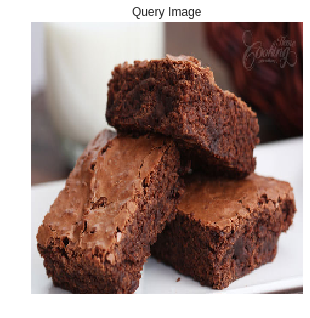

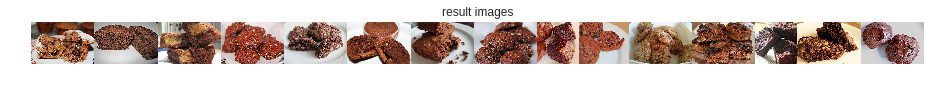

In [22]:
query_image, x = get_image_vgg('pred.jpg');
query_features = feat_extractor.predict(x)[0]

# do a query on a random image
idx_closest = get_closest_images_fast(query_features)
#print(idx_closest)

predicted_labels = [str(images[i]).split('/')[1] for i in idx_closest]
predicted_ids = [[str(images[i]).split('-')[1], str(images[i]).split('-')[2].split('.')[0], images[i].decode("utf-8")] for i in idx_closest]
#print(predicted_labels)

results_image = get_concatenated_images(idx_closest, 400)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
plt.axis('off')
imshow(query_image)
matplotlib.pyplot.title("Query Image");

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
plt.axis('off')
imshow(results_image)
matplotlib.pyplot.title("result images");

#pprint([images[i] for i in idx_closest])

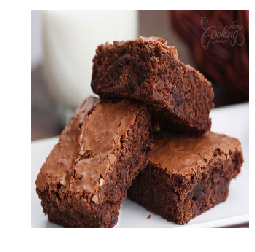

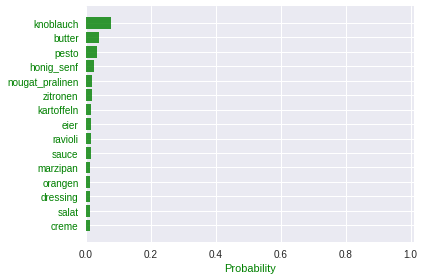

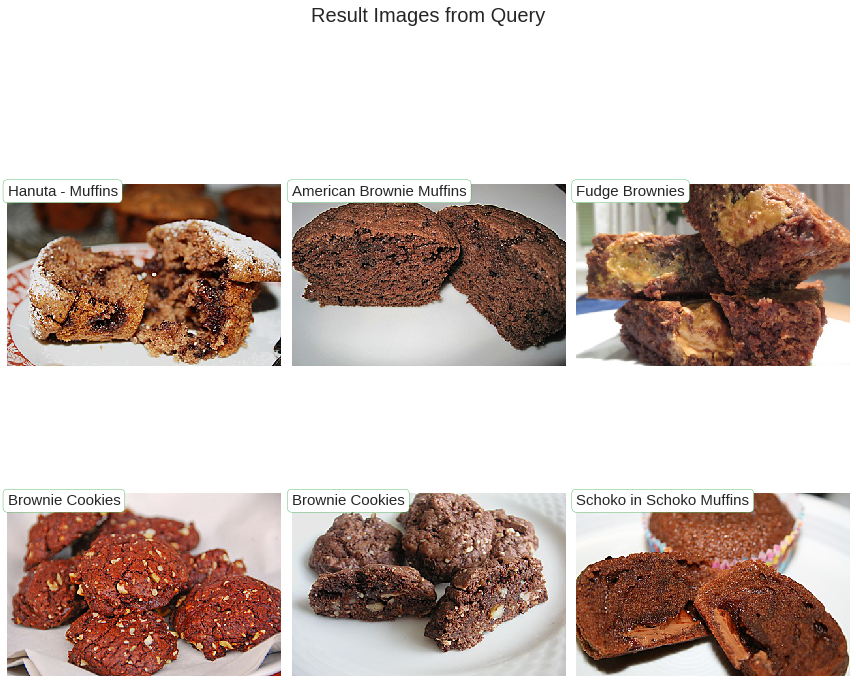

In [36]:
img, x = get_image_inc('pred.jpg')
probabilities = model_inc.predict(x)[0]
plot_preds(img, probabilities, 15)
pred_categories = []

for i, x in enumerate(np.argsort(-probabilities)[:15]):
  confidence = -np.sort(-probabilities)[i]
  #print(categories[x], confidence)
  pred_categories.append([categories[x], confidence])
  
predicted_labels_with_weights = []
for iii in predicted_labels:
  for iiii, ii in enumerate(pred_categories):
    no_result = False
    if ii[0] == iii:
      predicted_labels_with_weights.append([iii, ii[1]])
      break
    if iiii == len(pred_categories)-1:
      predicted_labels_with_weights.append([iii, 0])
      
predicted_labels_with_meta = [xi+yi for xi, yi in zip(predicted_labels_with_weights, predicted_ids)]
final_result = sorted(predicted_labels_with_meta, key=lambda predicted_labels_with_meta: predicted_labels_with_meta[1], reverse=True)

show_result_images(final_result[:6])

In [33]:
from werkzeug.wrappers import Request, Response
from flask import Flask

app = Flask(__name__)

@app.route("/")
def hello():
    return "Hello World!"

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 8000, app)

 * Running on http://localhost:8000/ (Press CTRL+C to quit)


In [34]:
!hostname

4be7927dba74


#Validate the feature extractor

In [ ]:
images_path = 'images'
max_num_images = 500

images_test = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images_test):
    images_test = [images_test[i] for i in sorted(random.sample(range(len(images_test)), max_num_images))]

print("keeping %d images to analyze" % len(images_test))

keeping 500 images to analyze


In [ ]:
images_test[:10]

['images/mousse_au_chocolat/mousse_au_chocolat-1574031264947519-12.jpg.jpg',
 'images/mousse_au_chocolat/mousse_au_chocolat-471971140739894-5.jpg.jpg',
 'images/mousse_au_chocolat/mousse_au_chocolat-518131147966806-5.jpg.jpg',
 'images/walnuss/walnuss-1212681227023517-29.jpg.jpg',
 'images/walnuss/walnuss-1461531251108576-15.jpg.jpg',
 'images/smoothie/smoothie-2732701425630334-0.jpg',
 'images/auflauf/auflauf-2901441442495329-0.jpg',
 'images/auflauf/auflauf-2726791425207004-0.jpg',
 'images/fenchel/fenchel-1389891244036944-0.jpg',
 'images/fenchel/fenchel-2117781341227357-0.jpg']

scipy.spatial.distance.euclidean: **200s** with **5 queries**

falconn.find_k_nearest_neighbors: **0.692s** with **5 queries**

1.   10 -> 4.55s
2.   100 -> 9.41s
3.   500 -> 17.4s

Accuracy: Size -> 200'000

**0.356075**

*   Top1: 23'318
*   Top5: 47'897




In [ ]:
%%time
top_1_accuracy, top_5_accuracy, totally_wrong = 0, 0, 0
for image_test in tqdm(images_test):
  query_image, x = get_image_vgg(image_test);
  query_features_test = feat_extractor.predict(x)[0]
  correct_label = image_test.split('/')[1]
  #print(correct_label)
  #matplotlib.pyplot.figure(figsize = (5,5))
  #imshow(query_image)
  #matplotlib.pyplot.title("Query Image")
  idx_closest_test = get_closest_images_fast(query_features_test)
  #print(idx_closest_test)
  predicted_labels = [str(images[i]).split('/')[1] for i in idx_closest_test]
  # Skip first label, falconn gets this right every time
  #print(predicted_labels[1:])
  #results_images_test = get_concatenated_images(idx_closest_test, 400)
  #matplotlib.pyplot.figure(figsize = (16,12))
  #imshow(results_images_test)
  #matplotlib.pyplot.title("result images")
  #plt.axis('off')
  if correct_label == predicted_labels[1]:
    top_1_accuracy += 1
  elif correct_label in predicted_labels[1:]:
    top_5_accuracy += 1
  else: totally_wrong += 1
    
print(top_1_accuracy)
print(top_5_accuracy)
print(totally_wrong)

100%|██████████| 500/500 [00:31<00:00, 15.82it/s]

42
82
376
CPU times: user 17.9 s, sys: 3.13 s, total: 21 s
Wall time: 31.6 s


In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

textfile = drive.CreateFile()
textfile.SetContentFile('vgg16_bottleneck_features.hdf5')
textfile.Upload()